# Red Wine Quality Prediction

Dataset source: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

## Project Setup

Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBClassifier

## Data Summarization and Visualization

Load the dataset

In [2]:
df = pd.read_csv("dataset/winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Generate the descriptive statistics of the dataset

In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Show the correlation matrix

In [5]:
df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


Visualize the data

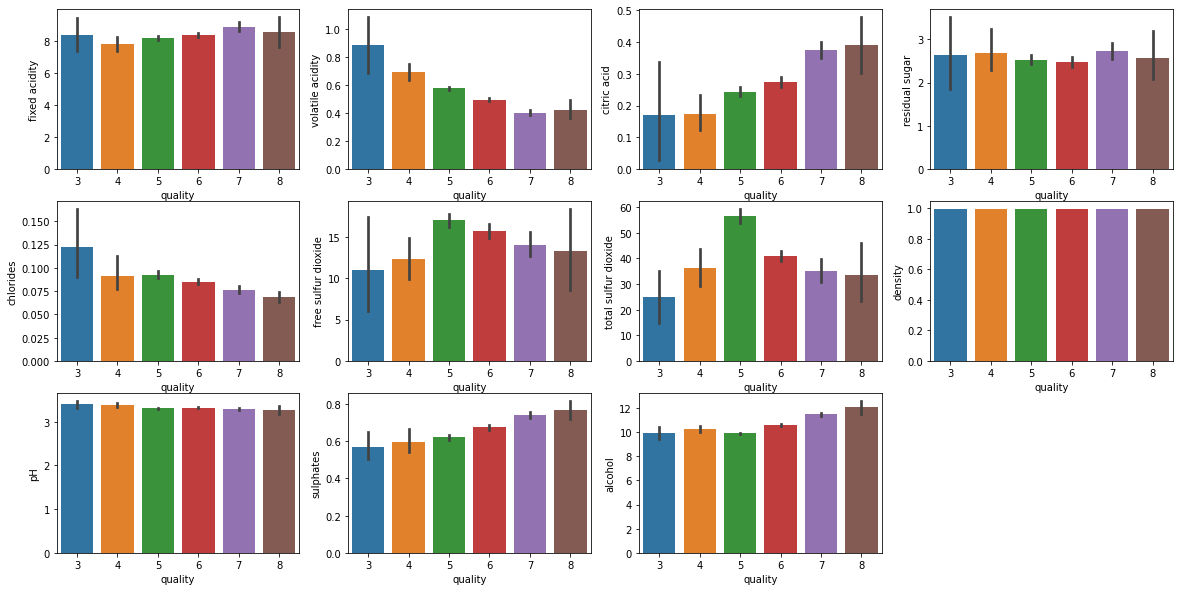

In [6]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10))
axes[2,3].set_axis_off()

sns.barplot(ax=axes[0, 0], data=df, x='quality', y='fixed acidity')
sns.barplot(ax=axes[0, 1], data=df, x='quality', y='volatile acidity')
sns.barplot(ax=axes[0, 2], data=df, x='quality', y='citric acid')
sns.barplot(ax=axes[0, 3], data=df, x='quality', y='residual sugar')
sns.barplot(ax=axes[1, 0], data=df, x='quality', y='chlorides')
sns.barplot(ax=axes[1, 1], data=df, x='quality', y='free sulfur dioxide')
sns.barplot(ax=axes[1, 2], data=df, x='quality', y='total sulfur dioxide')
sns.barplot(ax=axes[1, 3], data=df, x='quality', y='density')
sns.barplot(ax=axes[2, 0], data=df, x='quality', y='pH')
sns.barplot(ax=axes[2, 1], data=df, x='quality', y='sulphates')
sns.barplot(ax=axes[2, 2], data=df, x='quality', y='alcohol')
plt.show()


Show the class distribution

In [7]:
class_dist = df.groupby("quality").size()

for index, val in class_dist.iteritems():
    percentage = (val / sum(class_dist) * 100)
    print(f"Class {index} : {val} samples ({percentage:.2f}%)")

Class 3 : 10 samples (0.63%)
Class 4 : 53 samples (3.31%)
Class 5 : 681 samples (42.59%)
Class 6 : 638 samples (39.90%)
Class 7 : 199 samples (12.45%)
Class 8 : 18 samples (1.13%)


In [8]:
df["quality"] = [ 1 if x>=7 else 0 for x in df.quality] 
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [9]:
class_dist = df.groupby("quality").size()

for index, val in class_dist.iteritems():
    percentage = (val / sum(class_dist) * 100)
    print(f"Class {index} : {val} samples ({percentage:.2f}%)")

Class 0 : 1382 samples (86.43%)
Class 1 : 217 samples (13.57%)


Split the features and target

In [10]:
X = df.drop(["quality"], axis=1)
y = pd.DataFrame(df["quality"].copy())

Deal with imbalanced classes using SMOTE

In [11]:
#smote = SMOTE()
#X_smote, y_smote = smote.fit_resample(X, y)

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)
X_smote, y_smote = rus.fit_resample(X, y)

In [12]:
class_dist = y_smote.groupby("quality").size()

for index, val in class_dist.iteritems():
    percentage = (val / sum(class_dist) * 100)
    print(f"Class {index} : {val} samples ({percentage:.2f}%)")

Class 0 : 217 samples (50.00%)
Class 1 : 217 samples (50.00%)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [15]:
class_dist = y_smote.groupby("quality").size()

for index, val in class_dist.iteritems():
    percentage = (val / sum(class_dist) * 100)
    print(f"Class {index} : {val} samples ({percentage:.2f}%)")

Class 0 : 217 samples (50.00%)
Class 1 : 217 samples (50.00%)


In [16]:
X_test, y_test = smote.fit_resample(X_test, y_test)

In [17]:
class_dist = y_test.groupby("quality").size()

for index, val in class_dist.iteritems():
    percentage = (val / sum(class_dist) * 100)
    print(f"Class {index} : {val} samples ({percentage:.2f}%)")

Class 0 : 273 samples (50.00%)
Class 1 : 273 samples (50.00%)


In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Model Training

In [19]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [20]:
cv = cross_val_score(clf, X_train, y_train, cv=10)

In [21]:
print(f"cv score: {cv.mean():.3f}")

cv score: 0.948


In [22]:
y_train_pred = clf.predict(X_train)

In [23]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1109
           1       1.00      1.00      1.00      1109

    accuracy                           1.00      2218
   macro avg       1.00      1.00      1.00      2218
weighted avg       1.00      1.00      1.00      2218



In [24]:
clf.get_booster().get_score(importance_type="gain")

{'f0': 2.2063987255096436,
 'f1': 2.637747287750244,
 'f2': 1.599345326423645,
 'f3': 1.5136243104934692,
 'f4': 1.8138878345489502,
 'f5': 1.5590013265609741,
 'f6': 2.4670565128326416,
 'f7': 1.5320909023284912,
 'f8': 2.1531643867492676,
 'f9': 4.953411102294922,
 'f10': 12.496424674987793}

## Model Evaluation

In [25]:
y_test_pred = clf.predict(X_test)

In [26]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       273
           1       0.90      0.89      0.90       273

    accuracy                           0.90       546
   macro avg       0.90      0.90      0.90       546
weighted avg       0.90      0.90      0.90       546



In [27]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

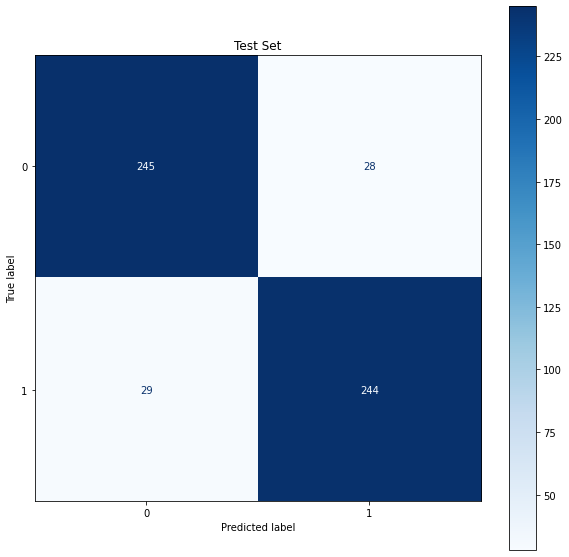

In [28]:
conf_mat = ConfusionMatrixDisplay(conf_matrix)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Test Set')
conf_mat.plot(cmap=plt.cm.Blues, ax=ax);

## Conclusion

In [29]:
#

#